PREDICTING CUSTOMER CHURN FOR VODAFONE
--------------------------------------

## 1. BUSINESS UNDERSTANDING
----------------------
Companies in the present business environment are always looking for ways to increase their profitability and revenue margins. Customer retention is an important area of focus for sector participants since it has an immediate influence on sustainability and long-term performance. Businesses are using the capabilities of machine learning to undertake churn analysis on their client base in order to accomplish this goal.

Objectives of the project
-------------------------


The objective of this project is to help a Vodafone telecommunications company use classification models to gain insight into their customer data, determine the lifetime value of each customer, pinpoint the major variables affecting customer churn rates, and create predictive models to ascertain whether a customer will leave or not.

## 2. DATA COLLECTION AND DATA PREPARATION

    2.1 DATA COLLECTION

Installations and Importing the necessary libraries

In [185]:
#Install pyodbc and python-dotenv
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [186]:
#Importing the necessary Libraries.
import pyodbc                    #just installed with pip
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import pandas as pd
import numpy as np
import os
import warnings 
import matplotlib.pyplot as plt
import re
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')


warnings.filterwarnings('ignore')

Getting dataset 1 from DB and loading/previewing

In [187]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [188]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection=pyodbc.connect(connection_string)

In [189]:
query="Select * from dbo.LP2_Telco_churn_first_3000"
data_1=pd.read_sql(query,connection)

In [190]:
data_1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [191]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


Dataset 1 has 21 columns whose dtypes is as follow *5 have bool dtype*, *2 have float64 dtype*, *1 int64* and *13 object dtypes*. the dataset also have 3000 rows(entries). We have *3 numerical columns* and *18 categorical columns*.

Getting dataset 2 and Dataset 3, loading/preview

In [192]:
#reading the excel file
data_2 = pd.read_excel("Telco-churn-second-2000.xlsx")

In [193]:
data_2.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
5,0516-QREYC,Female,1,No,No,24,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.30,459.95
6,9685-WKZGT,Male,1,No,No,14,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.95,1036.75
7,6022-UGGSO,Female,1,No,No,32,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,74.40,2276.95
8,8084-OIVBS,Female,0,No,No,11,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.00,211.95
9,8896-BQTTI,Male,0,No,No,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,25.00,25


In [194]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [195]:
data_2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Dataset 2 has 20 columns whose dtypes is as follow, *2 have float64 dtype*, *1 int64 dtype* and *17 object dtypes*. the dataset also have 1999 rows(entries). We have *3 numerical columns* and *17 categorical columns*.  Its missing the Churn Column. this mean its our dataset that will predict churn rate after creating our model.

getting dataset 3; loading and preview

In [196]:
#reading the csv file
data_3 = pd.read_csv("LP2_Telco-churn-last-2000.csv")

In [197]:
data_3.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No
5,2359-QWQUL,Female,0,Yes,No,39,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.70,4134.85,Yes
6,9103-TCIHJ,Female,0,No,No,15,Yes,Yes,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,55.70,899.8,Yes
7,7407-SUJIZ,Male,0,No,No,25,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.60,541.5,No
8,9150-KPBJQ,Female,0,No,No,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.65,116.85,No
9,0052-DCKON,Male,0,Yes,No,66,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,No,Bank transfer (automatic),115.80,7942.15,No


In [198]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [199]:
data_3.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Dataset 3 has 21 columns whose dtypes is as follow, *1 have float64 dtype*, *2 int64* and *18 object dtypes*. the dataset also have 2043 rows(entries). We have *3 numerical columns* and *18 categorical columns*.

## HYPOTHESIS FORMULATION
Null Hypothesis (H0): There is no significant relationship between customer characteristics and churn rate in the telecommunication company's customer base.

Alternative Hypothesis (H1): There is a significant relationship between customer characteristics and churn rate in the telecommunication company's customer base.

## SMART BUSINESS QUESTIONS
## Univariate Analysis:
1. Does the average MonthlyCharges differ significantly between customers who churn and those who do not?
## Bivariate Analysis:
2. Does the customer's tenure with the company influence their likelihood of churning?
3. Is there a significant difference in churn rates between customers who have InternetService and those who do not?
4. How does the presence or absence of OnlineSecurity and OnlineBackup impact the probability of customer churn?
5. Are customers who have PaperlessBilling more likely to churn compared to those who receive paper bills?
6. Does the choice of PaymentMethod (e.g., electronic check, credit card, etc.) have any correlation with customer churn rates?
## Multivariate Analysis:
7. How does the interaction between contract status, monthly charges, and tenure the likelihood of customer churn?

## 2.2 DATA CLEANING

All Columns are important based on our smart questions are and will assist in our analysis.


### 2.2.1 Cleaning the data_1

In [200]:
# checking the  data infor - 
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


Dataset 1 has 3000 rows an 21 rows. Some columns are showing as boolean, float, int and object datatype. Lets explore the datatypes.

In [201]:
#check data 1 datatypes
data_1.dtypes.value_counts()

object     13
bool        5
float64     2
int64       1
Name: count, dtype: int64

There are 13 object dtype columns, 2 float dtype columns, 5 bools and one integer dtypes column.

In [202]:
# Lets have a preview of entries in the dataset 1
data_1.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
5,9305-CDSKC,Female,False,False,False,8,True,True,Fiber optic,False,...,True,False,True,True,Month-to-month,True,Electronic check,99.650002,820.500000,True
6,1452-KIOVK,Male,False,False,True,22,True,True,Fiber optic,False,...,False,False,True,False,Month-to-month,True,Credit card (automatic),89.099998,1949.400024,False
7,6713-OKOMC,Female,False,False,False,10,False,None,DSL,True,...,False,False,False,False,Month-to-month,False,Mailed check,29.750000,301.899994,False
8,7892-POOKP,Female,False,True,False,28,True,True,Fiber optic,False,...,True,True,True,True,Month-to-month,True,Electronic check,104.800003,3046.050049,True
9,6388-TABGU,Male,False,False,True,62,True,False,DSL,True,...,False,False,False,False,One year,False,Bank transfer (automatic),56.150002,3487.949951,False


Replacing the bool rows with Yes or No where there is True and False respectively. The rows are: Partner, Dependents, PhoneService, PaperlessBilling, SeniorCitizen, MultipleLines, OnlineSecurity, DeviceProtection,TechSupport, StreamingTV, StreamingMovies and Churn

In [203]:
# Dealing rows with boolean values
data_1['Partner'] = data_1['Partner'].replace({True: 'Yes', False: 'No'})
data_1['Dependents'] = data_1['Dependents'].replace({True: 'Yes', False: 'No'})
data_1['PhoneService'] = data_1['PhoneService'].replace({True: 'Yes', False: 'No'})
data_1['PaperlessBilling'] = data_1['PaperlessBilling'].replace({True: 'Yes', False: 'No'})
data_1['SeniorCitizen'] = data_1['SeniorCitizen'].replace({True: 'Yes', False: 'No'})
data_1['MultipleLines'] = data_1['MultipleLines'].replace({True: 'Yes', False: 'No'})
data_1['OnlineSecurity'] = data_1['OnlineSecurity'].replace({True: 'Yes', False: 'No'})
data_1['DeviceProtection'] = data_1['DeviceProtection'].replace({True: 'Yes', False: 'No'})
data_1['TechSupport'] = data_1['TechSupport'].replace({True: 'Yes', False: 'No'})
data_1['StreamingTV'] = data_1['StreamingTV'].replace({True: 'Yes', False: 'No'})
data_1['StreamingMovies'] = data_1['StreamingMovies'].replace({True: 'Yes', False: 'No'})
data_1['Churn'] = data_1['Churn'].replace({True: 'Yes', False: 'No'})
data_1['OnlineBackup'] = data_1['OnlineBackup'].replace({True: 'Yes', False: 'No'})

In [204]:
#Lets check if the bool data type - false, true  has been handled.
data_1.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,None,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45,No,None,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
5,9305-CDSKC,Female,No,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes
6,1452-KIOVK,Male,No,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No
7,6713-OKOMC,Female,No,No,No,10,No,None,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No
8,7892-POOKP,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes
9,6388-TABGU,Male,No,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.150002,3487.949951,No


Now lets change datatypes for numerical to be floats and for categorical to object

In [205]:
# Convert 'Total Charges' column to numeric datatype, replacing any non-numeric values.
data_1['TotalCharges'] = pd.to_numeric(data_1['TotalCharges'], errors='coerce')

# Convert Total Charges column from object to float datatype
data_1['TotalCharges'] = data_1['TotalCharges'].astype(float)
print(data_1['TotalCharges'].dtype)

float64


In [206]:
# Convert tenure  columns from int. to float datatype
data_1['tenure'] = pd.to_numeric(data_1['tenure'], errors='coerce')
data_1['tenure'] = data_1['tenure'].astype(float)

print(data_1['tenure'].dtype)


float64


In [207]:
#Lets check data types again
data_1.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [208]:
data_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,3000.0,32.527333,24.637768,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,3000.0,65.347400,30.137053,18.400000,35.787499,70.900002,90.262501,118.650002
TotalCharges,2995.0,2301.278315,2274.987884,18.799999,415.250000,1404.650024,3868.725098,8564.750000


I. Checking for Duplicates and Remove

In [209]:
duplicates = data_1.duplicated(keep=False)

# Returns the total number of duplicates
duplicates_count = duplicates.value_counts()
duplicates_count

False    3000
Name: count, dtype: int64

Dataset 1 has no duplicates. Lets proceed with the missing values

II. Checking the MIssing values

In [210]:
data_1_missing = data_1.isnull().sum()
data_1_missing

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

The above codes shows that there are the missing values. the columns with highest missing values of 651 are OnlineSecurity,Online Backup,DeviceProtection, Techsupport.StreeamingTV and StreamingMovies. Lets calculate percentages of missing values to be able to see how to fill them

In [211]:
#Compute missing percentage o
missing_count = data_1['OnlineSecurity'].isnull().sum()
total_rows = data_1.shape[0]

missing_percentage = (missing_count / total_rows) * 100

print(f"Percentage of missing values in {'OnlineSecurity'}: {missing_percentage:.2f}%")

Percentage of missing values in OnlineSecurity: 21.70%


The highest columns with missing values has a 21% of the total rows. Cleaning up the missing values by filling categorical columns with 'Unknown' and numberical with median value.

In [212]:
# filling cat-columns with 'Unknown'
column_names = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for column_name in column_names:
    data_1[column_name].fillna('Unknown', inplace=True)

In [213]:
#fill in churn column missing value with mode value
# Calculate the mode of the 'Churn' column
mode_churn = data_1['Churn'].mode()[0]

# Fill missing values with the mode value
data_1['Churn'].fillna(mode_churn, inplace=True)

In [214]:
# Filling Num-cols with median value - TotalCharges
# Calculate the mean of charge
median_charge_data1= data_1['TotalCharges'].median()

# Replace NaN values with median value
data_1['TotalCharges'].fillna(median_charge_data1, inplace=True)

Lets check if the missing values has been handled.

In [215]:
#check missing values has been filled
data_1.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

All missing values has been handled lets rename columns 

In [216]:
# Renaming the columns to start with a capital letter
data_1.rename(columns={'gender': 'Gender', 'tenure': 'Tenure', 'customerID': 'CustomerID'}, inplace=True)

The Final Cleaned DATASET1 

In [217]:
data_1.head(10)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1.0,No,Unknown,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,No,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,No,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45.0,No,Unknown,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,No,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
5,9305-CDSKC,Female,No,No,No,8.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes
6,1452-KIOVK,Male,No,No,Yes,22.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No
7,6713-OKOMC,Female,No,No,No,10.0,No,Unknown,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No
8,7892-POOKP,Female,No,Yes,No,28.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes
9,6388-TABGU,Male,No,No,Yes,62.0,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.150002,3487.949951,No


The cleaned version of DATASET 1 has 3 numerical columns and 18 categorical columns.

### 2.2.2 Cleaning data_2

In [218]:
# checking the  data infor - 
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


Dataset 2 has 2000 rows an 20 rows. Some columns are showing as  float, int and object datatypes. Lets explore the datatypes.

In [219]:
#check data 1 datatypes
data_2.dtypes.value_counts()

object     17
int64       2
float64     1
Name: count, dtype: int64

In [220]:
# Lets have a preview of entries in the dataset 1
data_2.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
5,0516-QREYC,Female,1,No,No,24,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.30,459.95
6,9685-WKZGT,Male,1,No,No,14,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.95,1036.75
7,6022-UGGSO,Female,1,No,No,32,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,74.40,2276.95
8,8084-OIVBS,Female,0,No,No,11,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.00,211.95
9,8896-BQTTI,Male,0,No,No,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,25.00,25


Lets change numerical columns(Total Charges,Monthly Charge and Tenure) to show float dtype and categorical columns(the rest of columns) to show object dtypes

In [221]:
# Convert 'Total Charges' column to numeric datatype, replacing any non-numeric values.
data_2['TotalCharges'] = pd.to_numeric(data_2['TotalCharges'], errors='coerce')

# Convert Total Charges column from object to float datatype
data_2['TotalCharges'] = data_2['TotalCharges'].astype(float)
print(data_2['TotalCharges'].dtype)

float64


In [222]:
# Convert tenure  columns from int. to float datatype
data_2['tenure'] = pd.to_numeric(data_2['tenure'], errors='coerce')
data_2['tenure'] = data_2['tenure'].astype(float)

print(data_2['tenure'].dtype)

float64


Lets convert SeniorCitizen from binary(0,1) to NO or YES respectively

In [223]:
#Lets replace SeniorCitizen entries from binary ,0,1 to NO or YES respectively
data_2['SeniorCitizen'] = data_2['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,No,No,No,12.0,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,No,No,No,9.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80
2,9513-DXHDA,Male,No,No,No,27.0,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,No,No,Yes,27.0,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,No,Yes,Yes,1.0,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [224]:
#lets check DTYPES again
data_2.dtypes.value_counts()

object     17
float64     3
Name: count, dtype: int64

The SeniorCitizen Column has been converted to Object and entries changed to NO and YES, and numerical columns data types changed to floats. Lets deal with missing values and/or duplicates

I. Check for duplicated and remove them

In [225]:
# Check for duplicates
duplicates_data_2 = data_2.duplicated(keep=False)

# Returns the total number of duplicates
duplicates_count = duplicates_data_2.value_counts()
duplicates_count

False    2000
Name: count, dtype: int64

There are no duplicates to be handled in dataset 2.

II. Check for missing Values and handle them accordingly.

In [226]:
#checking null/missing values
missing_values_data_2 = data_2.isnull().sum()
missing_values_data_2

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64

We have missing Values only in the Total Charges columns. Lets fill them with median value

In [227]:
#Fill missing values with median value for total charges columns
# Calculate the mean of charge
median_charge = data_2['TotalCharges'].median()

# Replace NaN values with median value
data_2['TotalCharges'].fillna(median_charge, inplace=True)

In [228]:
#check if missing Values in dataset 2 has been resolved
data_2.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

The missing Values has been handled.now lets rename columns gender, tenure and customer ID to start with a capital letter to match the rest of the columns

In [229]:
# Renaming the columns to start with a capital letter
data_2.rename(columns={'gender': 'Gender', 'tenure': 'Tenure', 'customerID': 'CustomerID'}, inplace=True)

The FINAL Cleaned Dataset 2


In [230]:
data_2.head(10)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,No,No,No,12.0,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,No,No,No,9.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80
2,9513-DXHDA,Male,No,No,No,27.0,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,No,No,Yes,27.0,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,No,Yes,Yes,1.0,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
5,0516-QREYC,Female,Yes,No,No,24.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.30,459.95
6,9685-WKZGT,Male,Yes,No,No,14.0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.95,1036.75
7,6022-UGGSO,Female,Yes,No,No,32.0,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,74.40,2276.95
8,8084-OIVBS,Female,No,No,No,11.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.00,211.95
9,8896-BQTTI,Male,No,No,No,1.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,25.00,25.00


The cleaned version of DATASET 2 has 3 numerical columns and 17 categorical columns.

### 2.2.3 Cleaning data_3

In [231]:
# checking the  data infor - 
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [232]:
data_3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


I. Check for Duplicates and remove them

In [233]:
# Check for duplicates
duplicates = data_3.duplicated(keep=False)

# Returns the total number of duplicates
duplicates_count = duplicates.value_counts()
duplicates_count

False    2043
Name: count, dtype: int64

In [234]:
# Identifying the duplicate rows
duplicates = data_3[data_3.duplicated(keep=False)]
duplicates

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Our dataset 3 has no duplicates.

II. Checking for missing values

In [235]:
missing_values_data_3 = data_3.isnull().sum()
missing_values_data_3

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### We can see that there are no missing values. But missing values can be represented using '-', let's check 

In [236]:
# Replacing '-' with NaN
data_3.replace("—", np.nan, inplace=True)

# Check for missing values
missing_values_data_3 = data_3.isnull().sum()
missing_values_data_3

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

As you can see we have no missing values in dataset 3. lets do visual inspect categorical and numerical columns

In [237]:
# lets do a statistical summary
data_3.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
#lets inspect categorical columns
data_3.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Interpretation from the statistical description.
Most of the categorical columns has more than 2 unique values. For numerical columns some are displaying NAN unique values which could be caused by dtype of the columns lets inspect further the columns as below.
lets inspect categorical columns/numerical columns seperately to check missing values represented as None/NAN.

In [239]:
#lets inspect categorical columns with more than 2 unique values - online security,internet service,onlineback,
data_3['OnlineSecurity'].value_counts(ascending=False)

OnlineSecurity
No                     1029
Yes                     585
No internet service     429
Name: count, dtype: int64

In [240]:
data_3['InternetService'].value_counts(ascending=False)

InternetService
Fiber optic    905
DSL            709
No             429
Name: count, dtype: int64

In [241]:
data_3['OnlineBackup'].value_counts(ascending=False)

OnlineBackup
No                     911
Yes                    703
No internet service    429
Name: count, dtype: int64

In [242]:
data_3['PaymentMethod'].value_counts(ascending=False)

PaymentMethod
Electronic check             696
Mailed check                 476
Bank transfer (automatic)    438
Credit card (automatic)      433
Name: count, dtype: int64

All categorical columns has uniques values that cannot be assumed as missing. lets explore the dtype of all numerical columns and now check missing values again.

In [243]:
#lets explore the numerical columns
print(data_3['TotalCharges'].dtype)

object


In [244]:
print(data_3['tenure'].dtype)

int64


In [245]:
print(data_3['MonthlyCharges'].dtype)

float64


In [246]:
print(data_3['SeniorCitizen'].dtype)

int64


the numerical column total charges, is in object dataframe lets change to floats. Also change dtype to floats SeniorCitizen & tenure columns and check if there missing values. also Tenure column to float dtype

In [247]:
# Convert 'Total Charges' column to numeric datatype, replacing any non-numeric values.
data_3['TotalCharges'] = pd.to_numeric(data_3['TotalCharges'], errors='coerce')

# Convert Total Charges column from object to float datatype
data_3['TotalCharges'] = data_3['TotalCharges'].astype(float)
print(data_3['TotalCharges'].dtype)

float64


In [248]:
# Convert Total Charges and Senior Citizen columns from int. to float datatype
data_3['tenure'] = data_3['tenure'].astype(float)
print(data_3['tenure'].dtype)

float64


Lets convert SeniorCitizen from binary(0,1) to NO or YES respectively

In [249]:
#Lets replace SeniorCitizen entries from binary ,0,1 to NO or YES respectively
data_3['SeniorCitizen'] = data_3['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [250]:
#lets check again dtypes
data_3.dtypes.value_counts()

object     18
float64     3
Name: count, dtype: int64

We have 18 object columns i.e Categorical cols and 3 numerical columns with dtype as float

In [251]:
## Lets check for missing values again
data_3.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
Churn               0
dtype: int64

In [252]:
#check unique Values
data_3['TotalCharges'].value_counts(ascending=False)

TotalCharges
20.20      5
19.65      4
19.90      4
69.65      4
70.30      3
          ..
35.00      1
2106.30    1
20.85      1
649.65     1
6844.50    1
Name: count, Length: 1990, dtype: int64

Now we have missing values on Total Charges Column: Lets fill the missing values  with  median value.

In [253]:
#Fill missing values with median value for total charges columns
# Calculate the mean of charge
median_charge = data_3['TotalCharges'].median()

# Replace NaN values with median value
data_3['TotalCharges'].fillna(median_charge, inplace=True)
data_3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,No,No,No,6.0,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,No,No,No,19.0,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,No,Yes,Yes,69.0,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,No,Yes,Yes,11.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,No,Yes,No,64.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [254]:
#confirm missing values has been resolved
data_3.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The missing values has been handled. now lets rename columns gender, tenure and customer ID to start with a capital letter to match the rest of the columns

In [255]:
# Renaming the columns to start with a capital letter
data_3.rename(columns={'gender': 'Gender', 'tenure': 'Tenure', 'customerID': 'CustomerID'}, inplace=True)

#### Final Cleaned Dataset 3

In [256]:
data_3.head(10)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,No,No,No,6.0,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.70,No
1,8292-TYSPY,Male,No,No,No,19.0,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.50,Yes
2,0567-XRHCU,Female,No,Yes,Yes,69.0,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.10,No
3,1867-BDVFH,Male,No,Yes,Yes,11.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.20,Yes
4,2067-QYTCF,Female,No,Yes,No,64.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.40,No
5,2359-QWQUL,Female,No,Yes,No,39.0,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.70,4134.85,Yes
6,9103-TCIHJ,Female,No,No,No,15.0,Yes,Yes,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,55.70,899.80,Yes
7,7407-SUJIZ,Male,No,No,No,25.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.60,541.50,No
8,9150-KPBJQ,Female,No,No,No,6.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.65,116.85,No
9,0052-DCKON,Male,No,Yes,No,66.0,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,No,Bank transfer (automatic),115.80,7942.15,No


In [257]:
data_3.dtypes

CustomerID           object
Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

The cleaned version of DATASET 3 has 3 numerical columns and 18 categorical columns.

#### 2.2.4 DATA CONCATENATION
Combining the 2 datatsets to one dataset for data analysis using SMART questions.
Here we are going to **use DATASET 1 and DATASET 3** since they are our training dataset which will be used in designing our model.  They both have the **Churn Column**

In [258]:
#Concatnate our dataset.
# Create a list of the datasets
datasets = [data_1, data_3]

# Concatenate the datasets vertically
final_data = pd.concat(datasets, ignore_index=True)

In [259]:
#A preview of the data
final_data.head(10)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1.0,No,Unknown,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,No,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,No,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45.0,No,Unknown,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,No,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
5,9305-CDSKC,Female,No,No,No,8.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes
6,1452-KIOVK,Male,No,No,Yes,22.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No
7,6713-OKOMC,Female,No,No,No,10.0,No,Unknown,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No
8,7892-POOKP,Female,No,Yes,No,28.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes
9,6388-TABGU,Male,No,No,Yes,62.0,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.150002,3487.949951,No


In [260]:
#let check for missing values
final_data.isna().sum()

CustomerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [261]:
# Checking for duplicates.
duplicates_final = final_data[final_data.duplicated(keep=False)]
duplicates_final

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


There no duplicates or missing values in the concated dataset. lets check unique values

In [262]:
# Iterate through columns and show unique values for each column
for column in final_data.columns:
    unique_values = final_data[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in CustomerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in Gender: ['Female' 'Male']
Unique values in SeniorCitizen: ['No' 'Yes']
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in Tenure: [ 1. 34.  2. 45.  8. 22. 10. 28. 62. 13. 16. 58. 49. 25. 69. 52. 71. 21.
 12. 30. 47. 72. 17. 27.  5. 46. 11. 70. 63. 43. 15. 60. 18. 66.  9.  3.
 31. 50. 64. 56.  7. 42. 35. 48. 29. 65. 38. 68. 32. 55. 37. 36. 41.  6.
  4. 33. 67. 23. 57. 61. 14. 20. 53. 40. 59. 24. 44. 19. 54. 51. 26.  0.
 39.]
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['Unknown' 'No' 'Yes' 'No phone service']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes' 'Unknown' 'No internet service']
Unique values in OnlineBackup: ['Yes' 'No' 'Unknown' 'No internet service']
Unique values in DeviceProtection: ['No' 'Yes' 'Unknown' 'No 

## GENERATE THE EXCEL DATA/CSV file to be used in POWERBI Deployment

In [270]:
# convert file to csv_file
#final_data.to_csv(r'C:\\train data.csv', index=False)

print("csv file generated successfully.")

csv file generated successfully.


# 2.3 DATA ANALYSIS WITH SMART QUESTIONS

## UNIVARIATE ANALYSIS
**Question 1: "Does the average MonthlyCharges differ significantly between customers who churn and those who do not?"** 

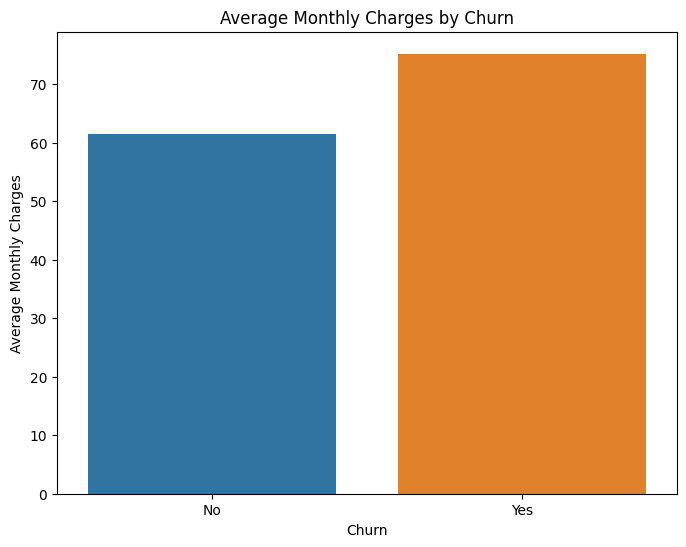

In [265]:
# 'MonthlyCharges' and 'Churn' are the column names
# where 'MonthlyCharges' is the numeric column and 'Churn' is the object column with 'Yes' and 'No' values
# Create a bar plot to compare the average monthly charges for churn and no churn groups
plt.figure(figsize=(8, 6))
sns.barplot(x='Churn', y='MonthlyCharges', data=final_data, ci=None)
plt.title("Average Monthly Charges by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Monthly Charges")
plt.xticks([0, 1], ['No', 'Yes'])  # Label x-axis with 'No' and 'Yes'
plt.show()

The bar plot illustrates the relationship between customer churn and their average monthly charges. We observe that as the monthly charges increase, there is a noticeable trend indicating a higher likelihood of churn. Specifically, customers with higher average monthly charges are more likely to churn compared to those with lower charges.

### BIVARATE ANALYSIS
Bivariate analysis involves the analysis of the relationship between two variables, examining how they interact or correlate with each other.

**Question 2: Does the customer's tenure with the company influence their likelihood of churning?**

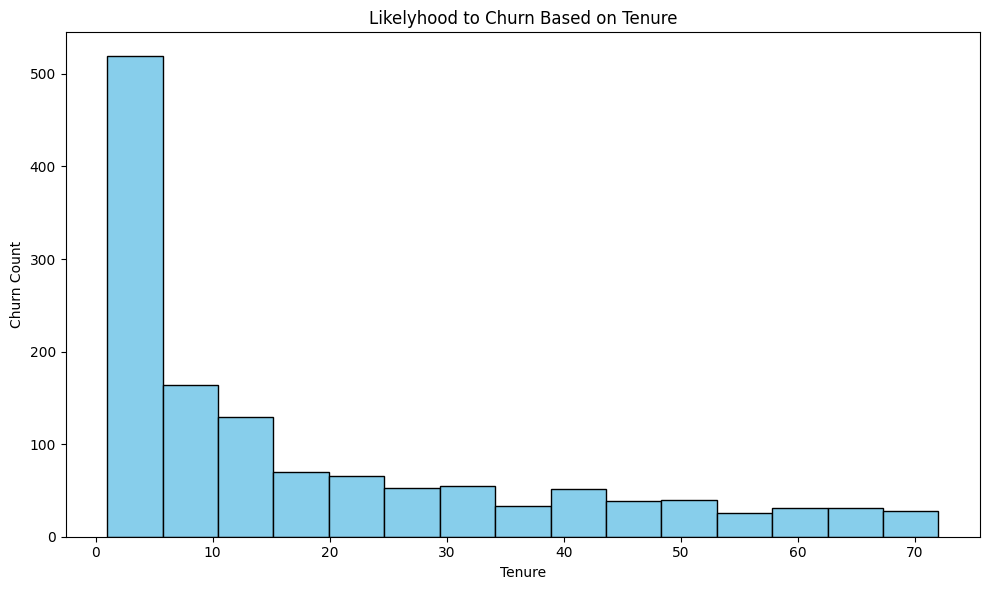

In [266]:
# Filter data for churned customers
churned_data = final_data[final_data['Churn'] == 'Yes']

# Create a histogram to visualize churn count based on tenure
plt.figure(figsize=(10, 6))
plt.hist(churned_data['Tenure'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Tenure')
plt.ylabel('Churn Count')
plt.title("Likelyhood to Churn Based on Tenure")
plt.tight_layout()
plt.show()

Based on the histogram visualization, it appears that newer customers (lower tenure values) tend to have a higher churn rate compared to customers who have been with the company for a longer period (higher tenure values). This suggests that there might be a correlation between the length of time a customer has been with the company (tenure) and their likelihood of churning.

**Question 3 - Is there a significant difference in churn rates between customers who have InternetService and those who do not?**

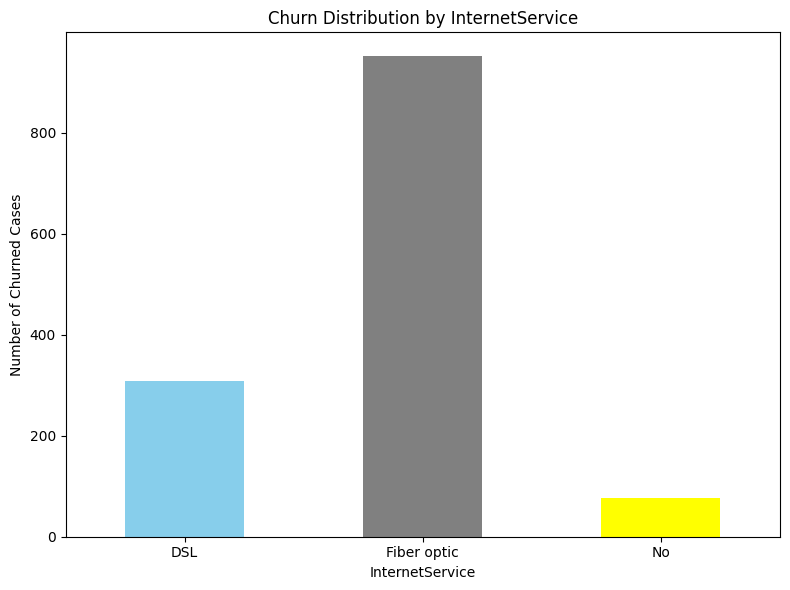

In [267]:
# 'Churn' and 'InternetService' are the column names
# where 'Churn' is the object column with 'Yes' and 'No' values, and 'InternetService' is the categorical column

# Filter the data for churned cases (Churn == 'Yes')
churned_data = final_data[final_data['Churn'] == 'Yes']

# Group by 'InternetService' and calculate the count of churned cases
churn_distribution_by_internet = churned_data.groupby('InternetService').size()
# Define colors for the bar plot
colors = ['skyblue', 'gray', 'yellow']

# Create a bar plot to visualize churn distribution by InternetService
plt.figure(figsize=(8, 6))
churn_distribution_by_internet.plot(kind='bar', color= colors)
plt.ylabel('Number of Churned Cases')
plt.title("Churn Distribution by InternetService")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot you created earlier shows the distribution of churned cases (Churn == 'Yes') among different categories in the 'InternetService' column. From the plot, we can observe the following:

**Fiber Optic** has the highest number of churned cases among the different Internet service providers. This indicates a relatively higher churn rate for customers who have opted for fiber optic internet service.

**The DSL service provider** has the second-highest number of churned cases. While the churn rate is lower compared to fiber optic, it is still higher than the "No" category.

**No Internet category**, which represents customers without any internet service, has the lowest number of churned cases. This indicates that customers without internet service are less likely to churn.

In summary, based on the distribution of churned cases among different Internet service providers, it appears that customers who have opted for fiber optic internet service have the highest churn rate, followed by DSL, while customers without internet service have the lowest churn rate.

**Question 4 -How does the presence or absence of OnlineSecurity and OnlineBackup impact the probability of customer churn?**

Churned Data comparison with online back and security

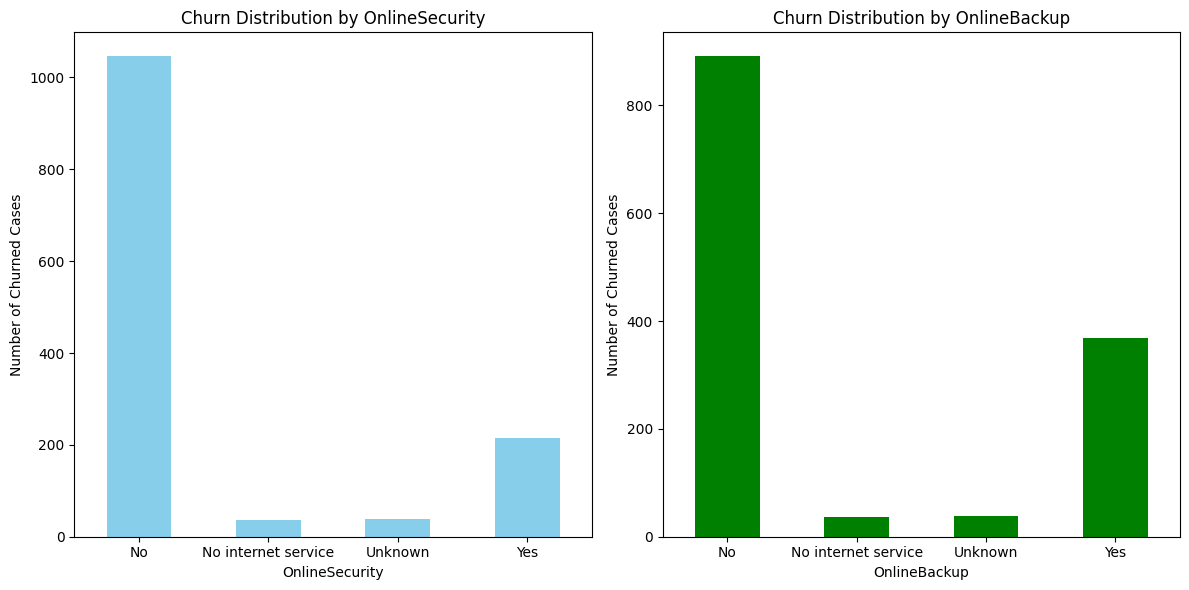

In [268]:
# Filter the data for churned cases (Churn == 'Yes')
churned_data = final_data[final_data['Churn'] == 'Yes']

# Group by 'OnlineSecurity' and calculate the count of churned cases
churn_distribution_by_security = churned_data.groupby('OnlineSecurity').size()

# Group by 'OnlineBackup' and calculate the count of churned cases
churn_distribution_by_backup = churned_data.groupby('OnlineBackup').size()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for OnlineSecurity
churn_distribution_by_security.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_ylabel('Number of Churned Cases')
axes[0].set_title("Churn Distribution by OnlineSecurity")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Bar plot for OnlineBackup
churn_distribution_by_backup.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_ylabel('Number of Churned Cases')
axes[1].set_title("Churn Distribution by OnlineBackup")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

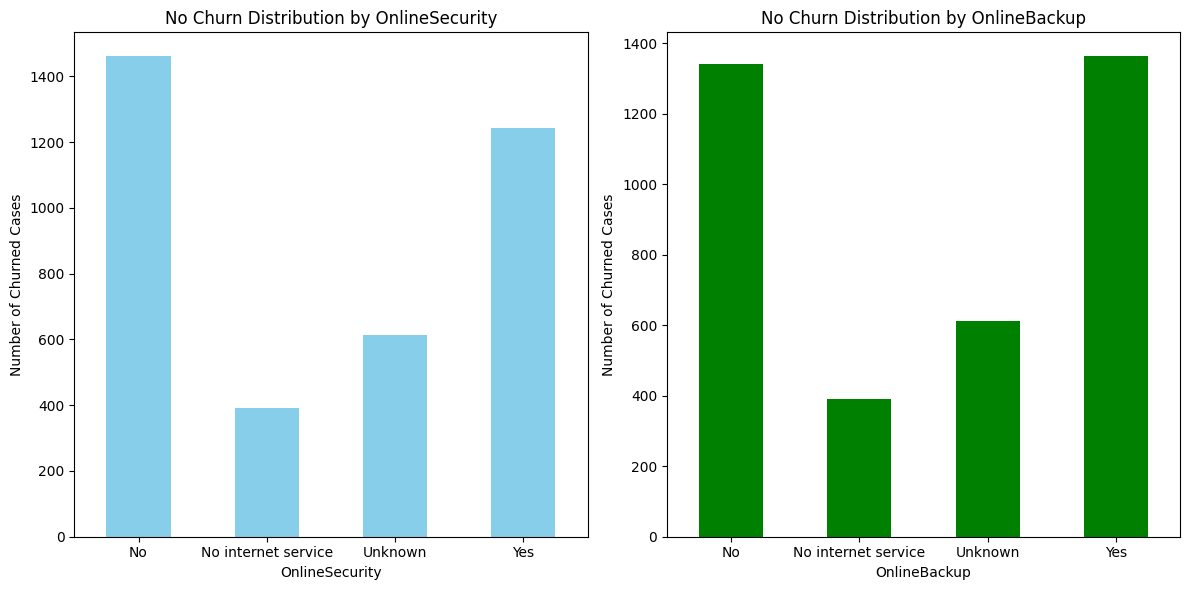

In [272]:
# Filter the data for churned cases (Churn == 'Yes')
no_churn = final_data[final_data['Churn'] == 'No']

# Group by 'OnlineSecurity' and calculate the count of churned cases
churn_distribution_by_security = no_churn.groupby('OnlineSecurity').size()

# Group by 'OnlineBackup' and calculate the count of churned cases
churn_distribution_by_backup = no_churn.groupby('OnlineBackup').size()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for OnlineSecurity
churn_distribution_by_security.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_ylabel('Number of Churned Cases')
axes[0].set_title("No Churn Distribution by OnlineSecurity")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Bar plot for OnlineBackup
churn_distribution_by_backup.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_ylabel('Number of Churned Cases')
axes[1].set_title("No Churn Distribution by OnlineBackup")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Churn Rate  by OnlineBackup:
The churn rate is higher when customers do not have online backup services compared to when they do.
Moreover, the churn count, which represents the actual number of customers churning, is significantly higher when there is no online backup service. This suggests that customers without online backup services are more likely to churn.

Churn Rate by OnlineSecurity:
Similar to the OnlineBackup scenario, the churn rate is higher for customers who do not have online security services.
Correspondingly, the churn count is notably higher when there is no online security. This reinforces the observation that customers without online security services exhibit a higher tendency to churn.

**Question 5 - Are customers who have PaperlessBilling more likely to churn compared to those who receive paper bills?**

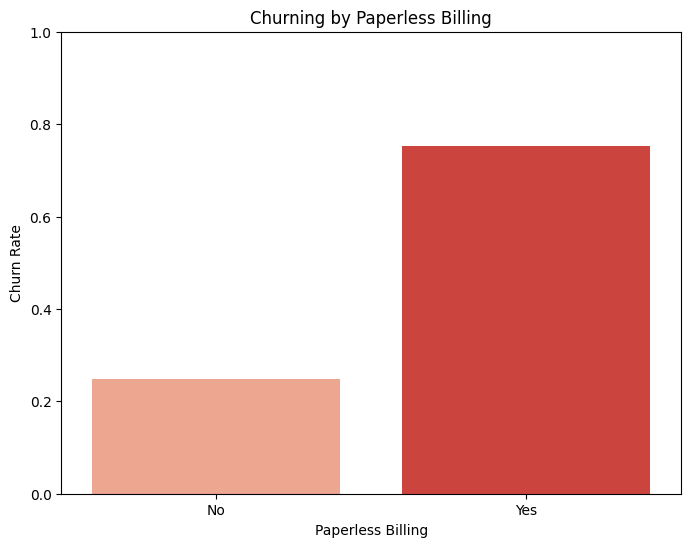

In [274]:
# Filter the data for churned customers
churned_data = final_data[final_data['Churn'] == 'Yes']

# Calculate churn rate for PaperlessBilling
churn_rate_by_billing = churned_data.groupby('PaperlessBilling')['Churn'].count() / len(churned_data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rate_by_billing.index, y=churn_rate_by_billing.values, palette="Reds")
plt.title("Churning by Paperless Billing")
plt.xlabel("Paperless Billing")
plt.ylabel("Churn Rate")
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.show()

Customers who have opted for PaperlessBilling appear to have a higher likelihood of churning compared to those who receive paper bills. The bar plot clearly shows that the churn rate is noticeably higher for customers with PaperlessBilling. This suggests that customers who have chosen to receive their bills electronically, without the use of paper, are more inclined to churn as opposed to those who continue to receive traditional paper bills. This observation could indicate that the method of billing communication may play a role in influencing customer retention

**Question 6 - "Does the choice of PaymentMethod (e.g., electronic check, credit card, etc.) have any correlation with customer churn rates**

<Figure size 1000x600 with 0 Axes>

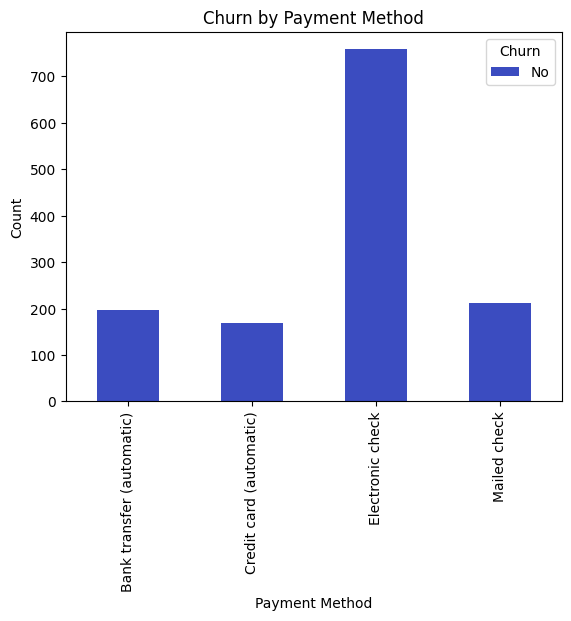

In [279]:
# Filter the data for churned customers
churned_data = final_data[final_data['Churn'] == 'Yes']

# Create a cross-tabulation between PaymentMethod and churn
payment_churn_cross_tab = pd.crosstab(churned_data['PaymentMethod'], churned_data['Churn'])

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
payment_churn_cross_tab.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title("Churn by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()


The stacked bar chart clearly illustrates the impact of payment methods on customer churn. Among the various payment methods, "Electronic check" has the highest churning rate, with a notable number of customers churning. This suggests that customers who opt for electronic check as their payment method are more likely to churn compared to those who choose other payment methods.

### MULTIVARIATE ANALYSIS

**Question 7 -How does the interaction between contract status, monthly charges, and tenure the likelihood of customer churn?**

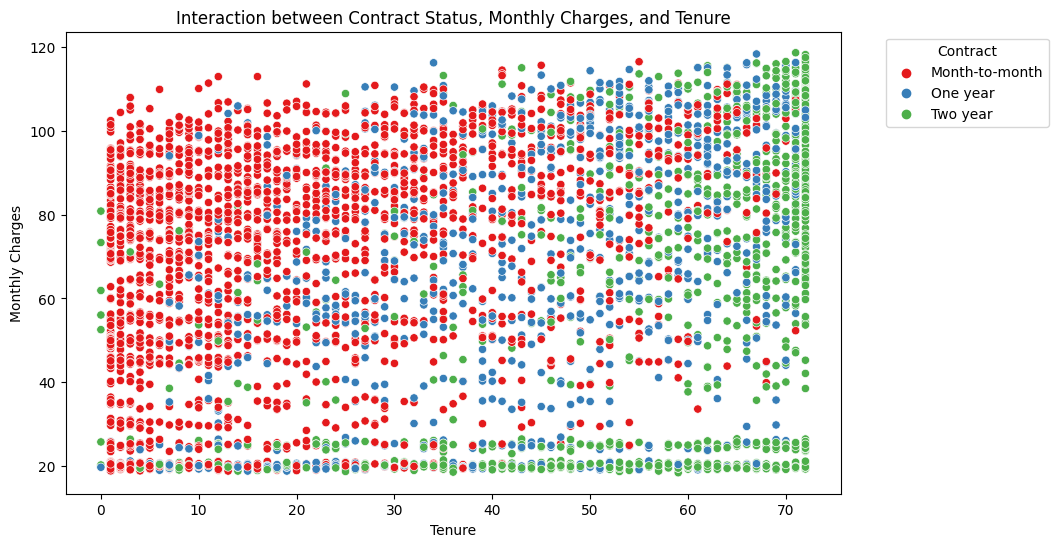

In [281]:
# Create a scatter plot with color encoding for contract status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tenure', y='MonthlyCharges', data=final_data, hue='Contract', palette='Set1')
plt.title("Interaction between Contract Status, Monthly Charges, and Tenure")
plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
# Move the legend outside of the chart
plt.legend(title='Contract', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The scatter plot illustrates a compelling relationship between contract type, monthly charges, and customer tenure in the company. It is evident that different contract types are associated with varying patterns of monthly charges and customer tenure.

Month-to-Month Contract (Blue Points): A substantial number of customers with month-to-month contracts are observed, especially among those with lower tenures. These customers tend to have a wide range of monthly charges, spanning from lower to higher values. This suggests that customers with shorter tenures may be exploring the service with a more flexible contract but might not be committing to higher monthly charges.

One-Year Contract (Orange Points): Customers with one-year contracts appear to be spread across a broader range of monthly charges. While there are customers with lower tenures who have opted for this contract type, there is a trend of slightly higher tenures being associated with slightly higher monthly charges.

Two-Year Contract (Green Points): The majority of customers with two-year contracts exhibit relatively higher tenures and are concentrated in a range of moderate to higher monthly charges. This indicates that customers with longer tenures are more likely to choose a two-year contract option, potentially in exchange for more stable or favorable monthly charges.

Overall, the plot implies that newer clients often opt for month-to-month contracts, possibly to evaluate the service, while older clients tend to prefer longer-term contracts, particularly two-year contracts, potentially indicating a higher level of commitment. The choice of contract type seems to correlate with both the desired monthly charges and the customer's tenure, suggesting a strategic alignment between contract flexibility, service evaluation, and long-term commitment.

### 3. MODELLING